# Exploratory Data Analysis - Customer Attributes Features

This notebook performs exploratory data analysis on the customer attributes data. This data contains demographic information that might be predictive of loan default behavior.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime

# Set plot style
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Loading the Data

In [2]:
# Load customer attributes data
attributes_data_path = '../data/features_attributes.csv'
attributes_df = pd.read_csv(attributes_data_path)

# Display basic information
print(f"Customer attributes data shape: {attributes_df.shape}")
attributes_df.head()

Customer attributes data shape: (12500, 6)


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1000,Alistair Barrf,18,913-74-1218,Lawyer,2023-05-01
1,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01
2,CUS_0x100b,Shirboni,19,#F%$D@*&8,Media_Manager,2024-03-01
3,CUS_0x1011,Schneyerh,44,793-05-8223,Doctor,2023-11-01
4,CUS_0x1013,Cameront,44,930-49-9615,Mechanic,2023-12-01


## 2. Data Overview and Basic Statistics

In [3]:
# Check data types
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer_ID    12500 non-null  object
 1   Name           12500 non-null  object
 2   Age            12500 non-null  object
 3   SSN            12500 non-null  object
 4   Occupation     12500 non-null  object
 5   snapshot_date  12500 non-null  object
dtypes: object(6)
memory usage: 586.1+ KB


In [4]:
# Check basic statistics
attributes_df.describe(include='all').T

,count,unique,top,freq
Customer_ID,12500,12500,CUS_0x1000,1
Name,12500,10139,Jessicad,6
Age,12500,301,26,364
SSN,12500,11798,#F%$D@*&8,703
Occupation,12500,16,_______,880
snapshot_date,12500,25,2024-08-01,543


## 3. Data Quality Check

In [5]:
# Check for missing values
missing_values = attributes_df.isnull().sum()
missing_percentage = (missing_values / len(attributes_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage
})

# Display only columns with missing values
missing_df = missing_df.loc[missing_df['Missing Values'] > 0]
if not missing_df.empty:
    print("Columns with missing values:")
    display(missing_df)
else:
    print("No missing values found in the dataset!")

No missing values found in the dataset!


In [6]:
# Check for duplicates
duplicate_rows = attributes_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


## 4. Examination of Problematic Fields

In [18]:
# Analyze the Age field
print("Sample of Age values:")
print(attributes_df['Age'].head(20))

# Check for invalid age values
def analyze_age_field(age_series):
    # Check for non-numeric characters
    contains_non_numeric = age_series.astype(str).str.contains(r'[^0-9\.-]')
    non_numeric_count = contains_non_numeric.sum()
    print(f"\nNumber of Age values containing non-numeric characters: {non_numeric_count}")
    
    # Check for underscores
    contains_underscore = age_series.astype(str).str.contains('_')
    underscore_count = contains_underscore.sum()
    print(f"Number of Age values containing underscores: {underscore_count}")
    
    if underscore_count > 0:
        print("\nSample of Age values with underscores:")
        print(age_series[contains_underscore].head(10))
    
    # Check for out-of-range values
    # First, create a cleaned version by removing underscores and converting to numeric
    cleaned_age = pd.to_numeric(age_series.astype(str).str.replace('_', ''), errors='coerce')
    out_of_range = (cleaned_age < 0) | (cleaned_age > 120)
    out_of_range_count = out_of_range.sum()
    print(f"\nNumber of age values out of reasonable range (0-120): {out_of_range_count}")
    
    if out_of_range_count > 0:
        print("\nSample of out-of-range Age values:")
        print(age_series[out_of_range].head(10))
    
    return cleaned_age

cleaned_age = analyze_age_field(attributes_df['Age'])

Sample of Age values:
0      18
1      26
2      19
3      44
4      44
5      27
6      15
7      52
8      31
9      26
10    40_
11     45
12     28
13     40
14     15
15     44
16     27
17     37
18     50
19     20
Name: Age, dtype: object

Number of Age values containing non-numeric characters: 637
Number of Age values containing underscores: 637

Sample of Age values with underscores:
10       40_
22       46_
50     3843_
52       30_
62       24_
70       22_
73       32_
101      26_
115      46_
150      34_
Name: Age, dtype: object

Number of age values out of reasonable range (0-120): 319

Sample of out-of-range Age values:
24      4746
50     3843_
95      5498
112     3553
124      236
143     5656
149      813
238    1248_
274     6657
276     5959
Name: Age, dtype: object


In [8]:
# Analyze the SSN field
print("Sample of SSN values:")
print(attributes_df['SSN'].head(20))

# Check for invalid SSN patterns
def analyze_ssn_field(ssn_series):
    # Define a simple pattern check for SSN (not comprehensive)
    # Standard US SSN pattern: XXX-XX-XXXX or XXXXXXXXX
    valid_pattern = r'^(\d{3}-\d{2}-\d{4}|\d{9})$'
    matches_pattern = ssn_series.astype(str).str.match(valid_pattern)
    invalid_count = (~matches_pattern).sum()
    print(f"\nNumber of SSN values not matching expected pattern: {invalid_count}")
    
    # Check for potentially corrupted data
    contains_special_chars = ssn_series.astype(str).str.contains('[^0-9\-]')
    special_char_count = contains_special_chars.sum()
    print(f"Number of SSN values containing unexpected characters: {special_char_count}")
    
    if special_char_count > 0:
        print("\nSample of SSN values with unexpected characters:")
        print(ssn_series[contains_special_chars].head(10))
    
    return valid_pattern

ssn_pattern = analyze_ssn_field(attributes_df['SSN'])

Sample of SSN values:
0     913-74-1218
1     063-67-6938
2       #F%$D@*&8
3     793-05-8223
4     930-49-9615
5     810-97-7024
6     731-19-8119
7     500-62-9044
8     692-71-7552
9       #F%$D@*&8
10    620-58-8045
11    230-22-9583
12    355-00-7832
13    155-72-8070
14    675-80-2033
15      #F%$D@*&8
16    808-81-2470
17      #F%$D@*&8
18    837-93-5062
19    264-84-8069
Name: SSN, dtype: object

Number of SSN values not matching expected pattern: 703
Number of SSN values containing unexpected characters: 703

Sample of SSN values with unexpected characters:
2      #F%$D@*&8
9      #F%$D@*&8
15     #F%$D@*&8
17     #F%$D@*&8
23     #F%$D@*&8
51     #F%$D@*&8
69     #F%$D@*&8
94     #F%$D@*&8
109    #F%$D@*&8
121    #F%$D@*&8
Name: SSN, dtype: object


<>:15: SyntaxWarning: invalid escape sequence '\-'
<>:15: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_60329/599730012.py:15: SyntaxWarning: invalid escape sequence '\-'
  contains_special_chars = ssn_series.astype(str).str.contains('[^0-9\-]')


In [9]:
# Analyze the Occupation field
print("Occupation value counts:")
occupation_counts = attributes_df['Occupation'].value_counts()
print(occupation_counts)

# Check for placeholder or missing values
placeholder_pattern = r'^_+$'
has_placeholder = attributes_df['Occupation'].astype(str).str.match(placeholder_pattern)
placeholder_count = has_placeholder.sum()
print(f"\nNumber of Occupation values that are just underscores: {placeholder_count}")

Occupation value counts:
Occupation
_______          880
Lawyer           828
Architect        795
Engineer         793
Accountant       791
Scientist        789
Teacher          782
Mechanic         780
Media_Manager    780
Developer        780
Entrepreneur     776
Journalist       761
Doctor           760
Musician         741
Manager          736
Writer           728
Name: count, dtype: int64

Number of Occupation values that are just underscores: 880


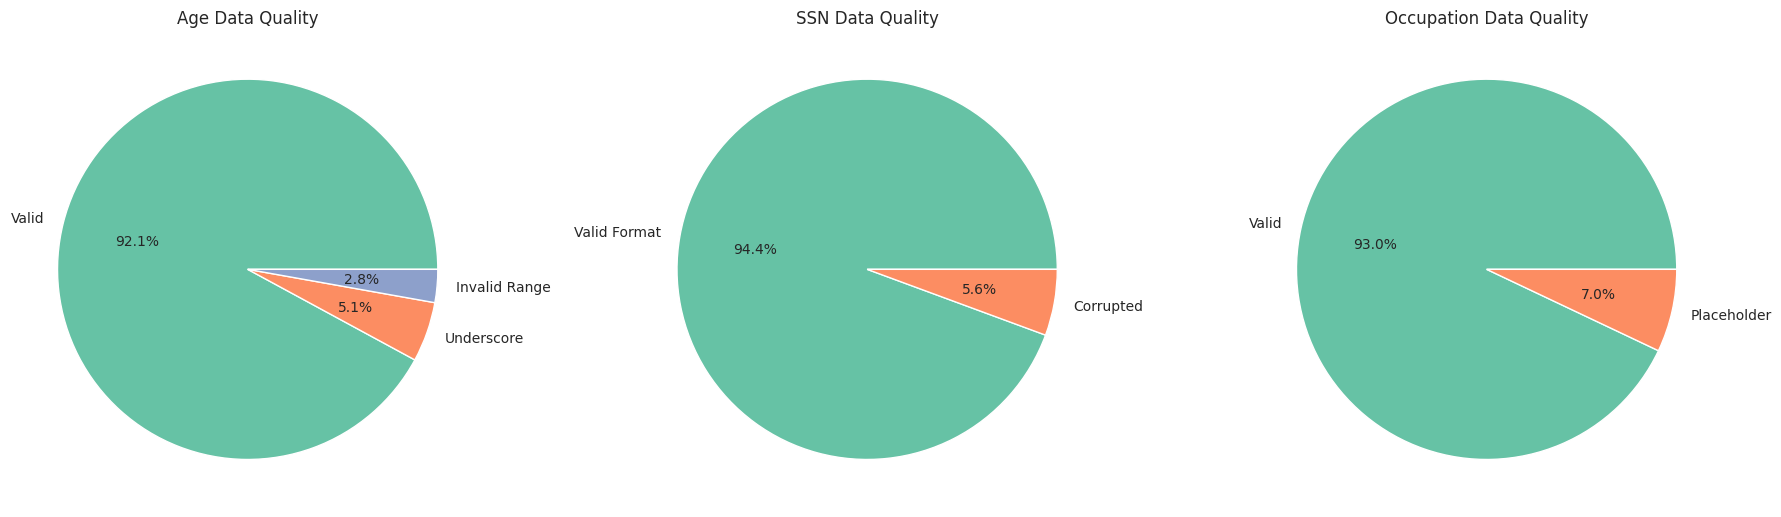

In [22]:
# Calculate data quality metrics
total_records = len(attributes_df)

# Age quality issues
age_underscore = attributes_df['Age'].astype(str).str.contains('_').sum()
age_invalid = ((cleaned_age < 18) | (cleaned_age > 90) | pd.isna(cleaned_age)).sum() - age_underscore
age_valid = total_records - age_underscore - age_invalid

# SSN quality issues
ssn_corrupted = attributes_df['SSN'].astype(str).str.contains('[^0-9\\-]').sum()
ssn_valid = total_records - ssn_corrupted

# Occupation quality issues
occupation_placeholder = attributes_df['Occupation'].astype(str).str.match(r'^_+$').sum()
occupation_valid = total_records - occupation_placeholder

# Create pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Age quality pie chart
axes[0].pie([age_valid, age_underscore, age_invalid], 
        labels=['Valid', 'Underscore', 'Invalid Range'],
        autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'])
axes[0].set_title('Age Data Quality')

# SSN quality pie chart
axes[1].pie([ssn_valid, ssn_corrupted], 
        labels=['Valid Format', 'Corrupted'],
        autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'])
axes[1].set_title('SSN Data Quality')

# Occupation quality pie chart
axes[2].pie([occupation_valid, occupation_placeholder], 
        labels=['Valid', 'Placeholder'],
        autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'])
axes[2].set_title('Occupation Data Quality')

plt.tight_layout()
plt.show()

## 5. Distribution Analysis

In [11]:
# Count unique customers
unique_customers = attributes_df['Customer_ID'].nunique()
print(f"Number of unique customers: {unique_customers}")

Number of unique customers: 12500


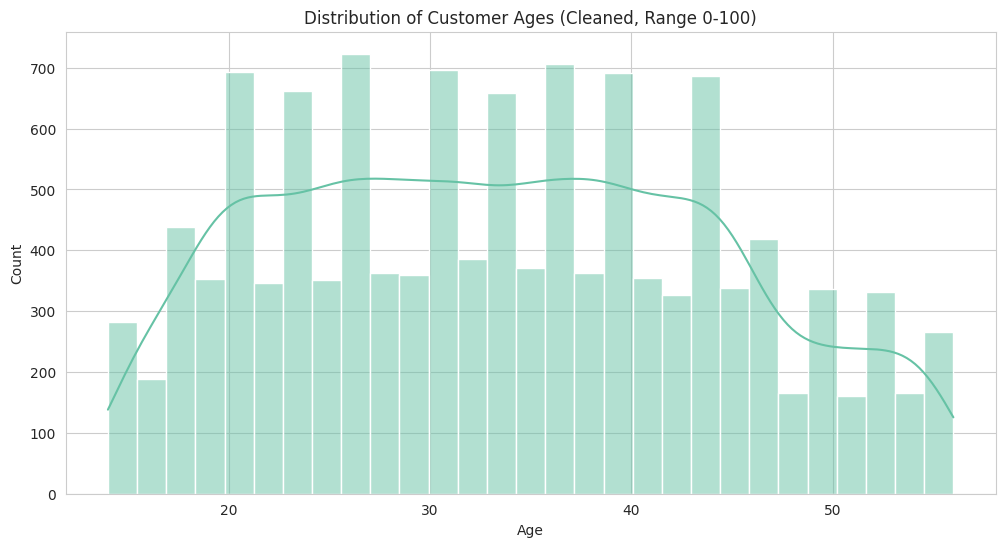

In [12]:
# Plot age distribution
plt.figure(figsize=(12, 6))

# Plot the cleaned age distribution
sns.histplot(cleaned_age[cleaned_age.between(0, 100)], kde=True)
plt.title('Distribution of Customer Ages (Cleaned, Range 0-100)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

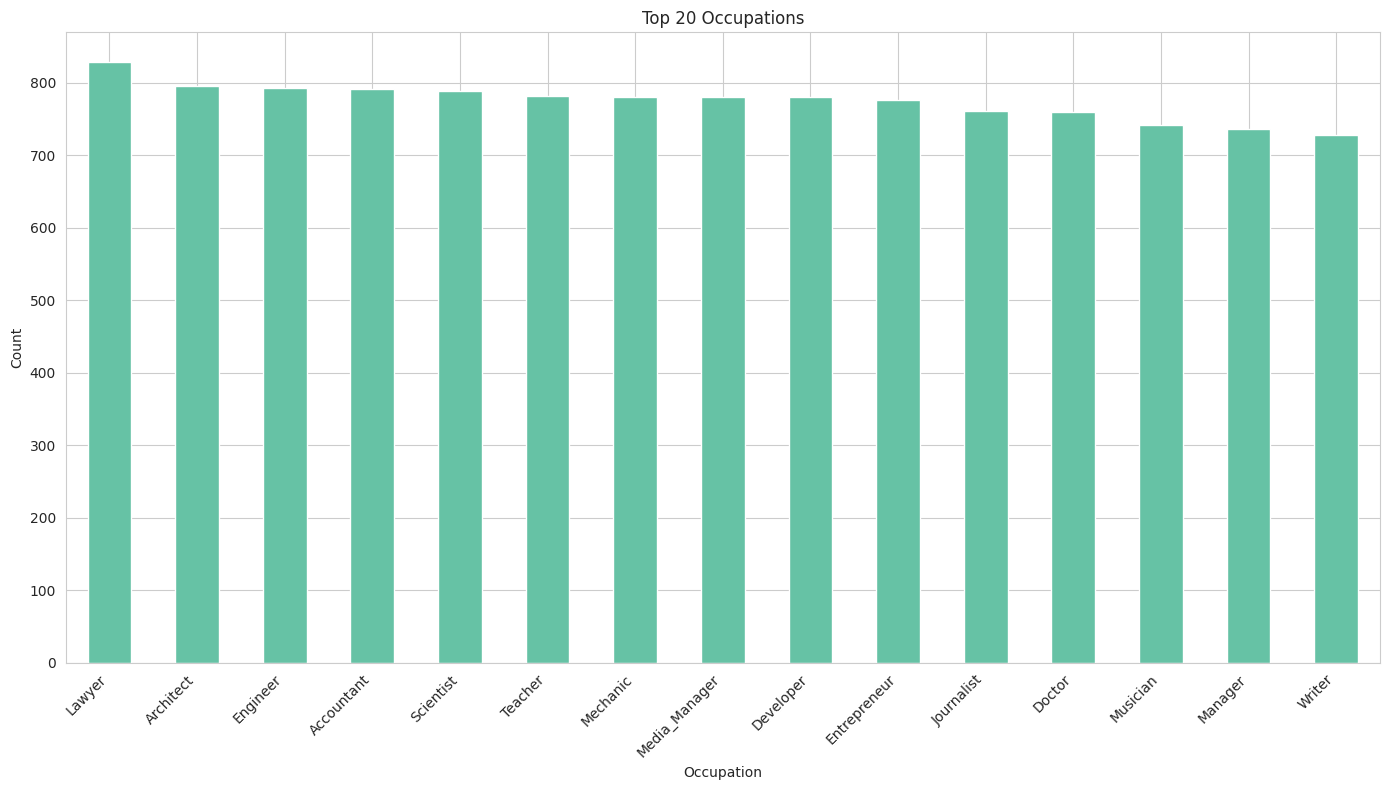

In [13]:
# Analyze occupation distribution
plt.figure(figsize=(14, 8))
# Filter out the placeholder values and show top 20 occupations
valid_occupations = occupation_counts[~occupation_counts.index.str.match(placeholder_pattern)].head(20)
valid_occupations.plot(kind='bar')
plt.title('Top 20 Occupations')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

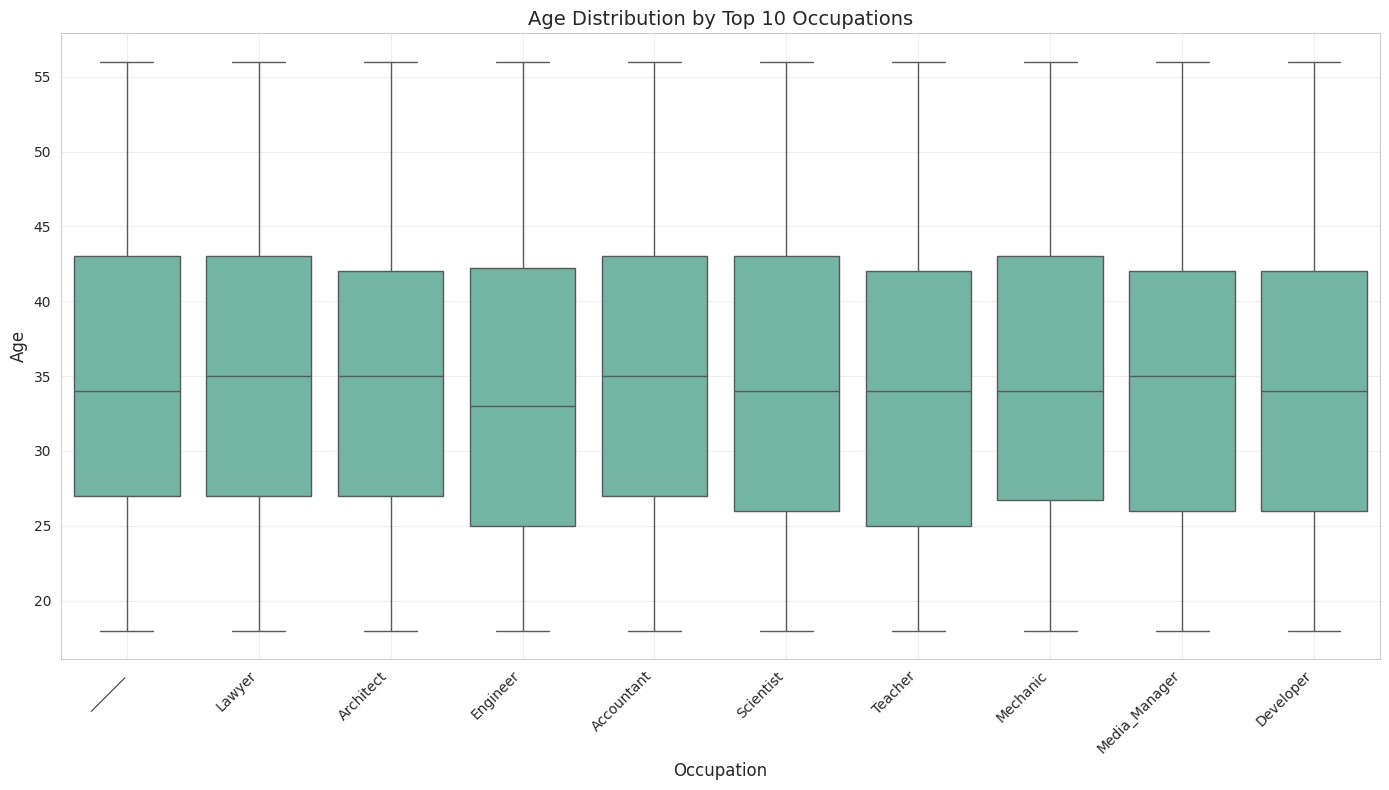

In [ ]:
#  Relationship Between Age and Occupation"

# Create a box plot to visualize age distribution by occupation
# Filter to top occupations and valid ages for better visualization
top_10_occupations = attributes_df['Occupation'].value_counts().head(10).index
valid_age_mask = (cleaned_age >= 18) & (cleaned_age <= 90)
occupation_age_df = pd.DataFrame({
    'Occupation': attributes_df['Occupation'],
    'Age': cleaned_age
})
occupation_age_df = occupation_age_df[
    occupation_age_df['Occupation'].isin(top_10_occupations) & 
    valid_age_mask
]

plt.figure(figsize=(14, 8))
sns.boxplot(x='Occupation', y='Age', data=occupation_age_df, order=top_10_occupations)
plt.title('Age Distribution by Top 10 Occupations', fontsize=14)
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Summary and Recommendations for Data Pipeline

### Key Findings:
- Age field quality: 92.1% valid entries, 5.1% contain underscores, and 2.8% fall outside reasonable age range (as shown in data quality analysis)
- SSN data includes 5.6% corrupted entries with consistent pattern "#F%$D@*&8"
- Occupation field contains 7.0% placeholder entries ("_______")
- Age distribution across occupations is relatively consistent, with median ages ranging from 33-35 years across top professions
- Most occupations show similar age distributions, with Engineers displaying a slightly lower median age
- Customer demographic data is largely static with no significant variations observed across snapshots
- Each customer typically has a single record, consistent with the nature of demographic data

### Recommendations for Bronze Layer:
- Load raw data without modifications to preserve original values
- Add data quality flags to identify problematic records during ingestion 
- Implement comprehensive data lineage tracking for audit purposes
- Create data quality metrics to track issues by data source

### Recommendations for Silver Layer:
- Clean the Age field by removing underscores and validating against reasonable range (18-90)
- Flag extreme Age values (>90 or <18) for review or replacement
- Handle corrupted SSN data by creating a validity flag and standardizing format
- Replace placeholder Occupation values ('_______') with standardized 'Unknown' marker
- Implement data type enforcement (string for categorical fields, numeric for Age)
- Create consistency checks for core demographic fields

### Recommendations for Gold Layer:
- Create single high-quality record per customer with appropriate data cleaning applied
- Generate age group features (e.g., 18-25, 26-35, 36-45, etc.) for segmentation analysis
- Create occupation category groupings from standardized values
- Develop data quality score feature to flag records with multiple data issues
- Design categorical encoding strategy compatible with machine learning algorithms
- Create occupation-based features that leverage the relationship between occupation and other attributes
- Implement feature flags to indicate which demographic attributes are present for each customer